In [2]:
from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
from PIL import Image
from sklearn.decomposition import KernelPCA

In [13]:
import glob
from PIL import Image
import matplotlib.image as mpimg

albacore_image_files = glob.glob('train/LAG/*.jpg')
# print(image_files)
albacore_image_list = []
size = 300, 300

for filename in albacore_image_files:
    image=Image.open(filename).resize(size).convert('LA')
    albacore_image_list.append(image)

In [17]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])



igs = np.array([rgb2gray(mpimg.imread(image)) for image in albacore_image_files])


In [18]:
igs.shape

(67, 720, 1280)

In [19]:
train_data = igs.astype('float32')
train_data = train_data / 255
igs_pca = train_data.reshape(67, (train_data.shape[1]*train_data.shape[2]))
igs_pca.shape

(67, 921600)

In [22]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 50
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, igs_pca.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(igs_pca)
eigenfaces = pca.components_.reshape((n_components, train_data.shape[1], train_data.shape[2]))

Extracting the top 50 eigenfaces from 67 faces
CPU times: user 18.7 s, sys: 370 ms, total: 19.1 s
Wall time: 5.33 s


In [23]:
pca.components_.shape

(50, 921600)

In [24]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [25]:
plot_explained_variance(pca)

In [26]:

n_components = 50
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, igs.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(igs_pca)

Extracting the top 50 eigenfaces from 67 faces
CPU times: user 1.83 s, sys: 106 ms, total: 1.94 s
Wall time: 603 ms


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=50,
     remove_zero_eig=False, tol=0)

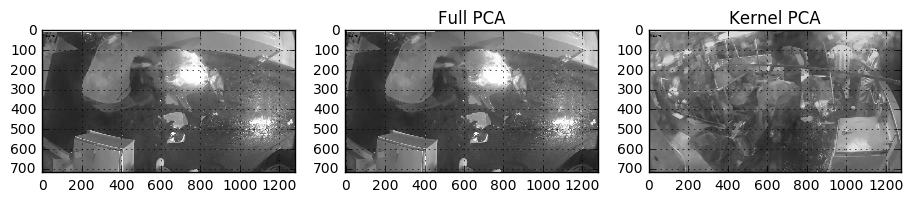

In [45]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods
X = igs_pca
n_samples, n_features = igs_pca.shape
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    plt.show()

    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

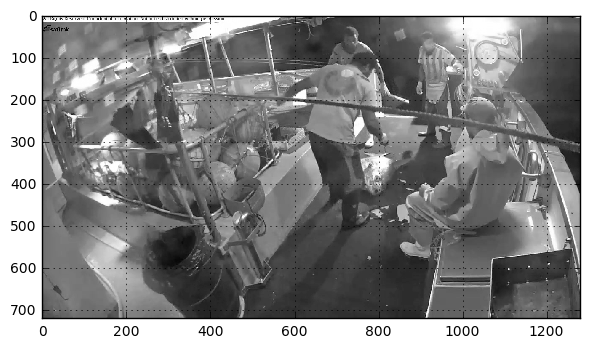

In [46]:
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2]))
imshow(img)
plt.grid()
plt.show()

In [43]:
gradient_mag

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00225045,  0.00531361, ...,  0.00855656,
         0.00278304,  0.        ],
       [ 0.        ,  0.00487083,  0.00649634, ...,  0.00302318,
         0.00966951,  0.        ],
       ..., 
       [ 0.        ,  0.00302741,  0.00302741, ...,  0.23198605,
         0.12169849,  0.        ],
       [ 0.        ,  0.00302741,  0.00302741, ...,  0.23198605,
         0.12169849,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

/Users/rupalsanghavi/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



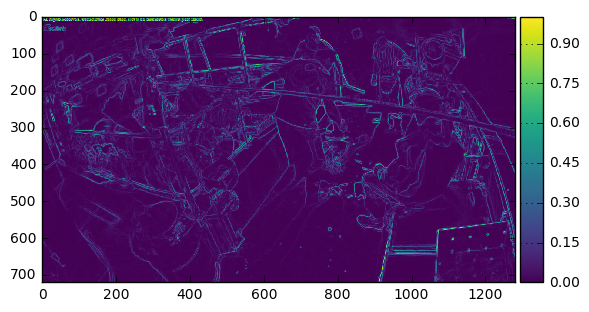

In [48]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()
plt.show()

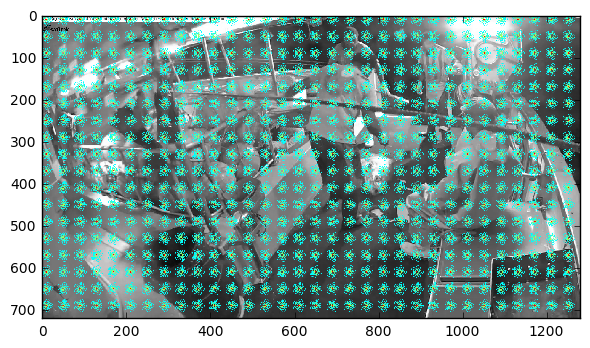

In [50]:
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()
plt.show()

In [54]:
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(70, 126, 72)
635040


In [56]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(train_data.shape[1], train_data.shape[2]))
test_feature.shape

CPU times: user 1.22 s, sys: 404 ms, total: 1.62 s
Wall time: 1.63 s


(917280,)

In [47]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, ((train_data.shape[1], train_data.shape[2])))
gabr_feature

array([  3.84499490e-01,   2.84291785e-02,   9.41866577e-01,
         1.00422795e+00,   1.17543586e-01,   2.76562385e-03,
         9.80897963e-01,   1.15469924e+00,   2.59371012e-01,
         1.23224901e-02,   8.85041177e-01,   8.63952331e-01,
         3.86885396e-04,   1.29015316e-05,  -8.76265541e-02,
         1.16240219e+02,   3.84502977e-01,   2.84345206e-02,
         9.42513108e-01,   1.00659126e+00,   1.17708258e-01,
         2.77037849e-03,   9.96713042e-01,   1.18518286e+00,
         2.61617184e-01,   1.25528257e-02,   8.91705036e-01,
         8.79950800e-01,   6.23128872e-05,   5.19369996e-06,
         3.27412374e-02,   8.07981653e+01,   3.84499580e-01,
         2.84399390e-02,   9.43152964e-01,   1.00869374e+00,
         1.17543571e-01,   2.81612622e-03,   1.03108323e+00,
         1.37250195e+00,   2.59371042e-01,   1.24129932e-02,
         9.01503325e-01,   9.02477724e-01,   3.86885338e-04,
         2.14931006e-05,  -2.45016351e-01,   1.27537948e+02,
         3.84502947e-01,

In [57]:
0.019 * len(X) # approximate how long it may run

1.273

In [43]:
train_data.shape[3]

3

In [58]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (train_data.shape[1], train_data.shape[2]))
print(daisy_features.shape)

CPU times: user 1min 21s, sys: 26.4 s, total: 1min 48s
Wall time: 1min 48s
(67, 917280)


In [59]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 328 ms, sys: 4.17 ms, total: 332 ms
Wall time: 165 ms


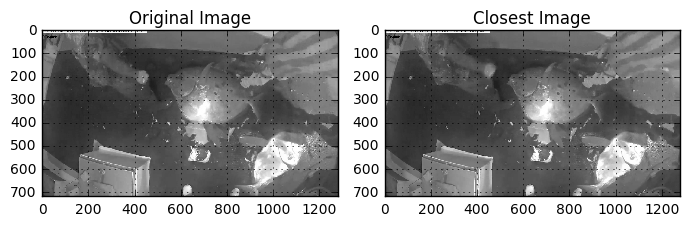

In [64]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((train_data.shape[1], train_data.shape[2])))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((train_data.shape[1], train_data.shape[2])))
plt.title("Closest Image")
plt.grid()
plt.show()

In [51]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, ((train_data.shape[1], train_data.shape[2])))
print(gabor_stats.shape)

CPU times: user 2min 57s, sys: 4.3 s, total: 3min 1s
Wall time: 3min 1s
(67, 64)


In [70]:
from ipywidgets import fixed
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Next Closest Image ")
    plt.grid()
    plt.show()


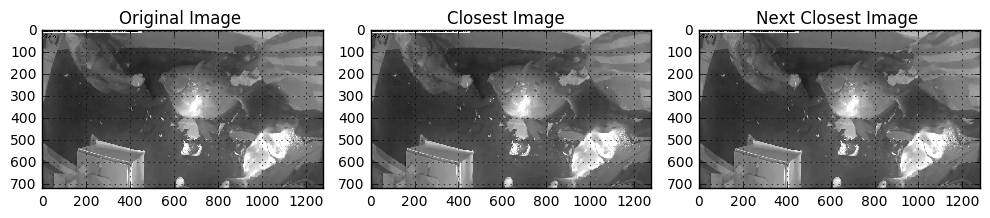

In [71]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)